In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Softmax
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ks_2samp
from graph_utils import avg_path_length
from graph_utils import get_cluster_coeff

In [10]:
nx.average_clustering(world.G)

0.33942924687605547

In [11]:
#Run me

nA = 5
class Node:
    '''kekw'''
    def __init__(self, Q):
        self.Q = Q #Q-func
        self.E = [] #Experience pool

def initQ(in_size, i, lr):
    '''Initializes Q-approximator for 
     - in_size : Size of input (should be number of states + number of actions)
     - i : 
    '''
    input_layer = Input(shape = (in_size,))
    dense_1 = Dense(128, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(input_layer)
    dense_2 = Dense(128, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(dense_1)
    dense_3 = Dense(64, activation = 'relu', use_bias = True, kernel_initializer="glorot_uniform")(dense_2)
    o = Dense(1, activation = None, use_bias = True, kernel_initializer="glorot_uniform")(dense_3)
    
    Q = Model(input_layer, o, name = "Q" + str(i))

#     def mse(y_true, y_pred):
#         return tf.math.reduce_mean(tf.math.square(y_true - y_pred)) * 0.5
    
    optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0)
    loss =  tf.keras.losses.MeanSquaredError()

    Q.compile(loss = loss, optimizer = optimizer)
                           
    return Q

class World:
    def __init__(self, n, num_agents):
        #self.state = np.zeros((num_agents, n * n)) #State, 46 x 100
        self.state_nums = np.zeros((num_agents,), dtype = int)
        self.n = n
        self.G = nx.Graph()
        self.G.add_nodes_from(range(num_agents))
        self.num_agents = num_agents
        
        for m in range(num_agents): #Start agents in random states
            r = np.random.randint(0, n * n)
            #self.state[m, r] = 1
            self.state_nums[m] = r
    
    def get_pos(self):
        out = []
        for i in range(self.num_agents):
            loc = self.state_nums[i]
            y, x = loc // self.n, loc % self.n
            x += np.random.uniform()
            y += np.random.uniform()
            out.append((x, y))
        return dict(enumerate(out, start = 0))
        
    def update_G(self):
        '''
        Searches for agents in the same state, and adds one to their edge's weight
        Also decreases any existing connections that are not maintained's weights by 1
        Removes any connections that have weight leq to 0
        '''
        updated = []
        rewards = np.zeros((self.num_agents, 1))
        for ag in range(self.state_nums.shape[0]): 
            #TODO: Maybe replace with np where to add edges?
            for tg in range(self.state_nums.shape[0]):
                #If same state, create/add weight to edge
                if ag != tg and self.state_nums[ag] == self.state_nums[tg] and (tg, ag) not in updated: 
                    if not self.G.has_edge(ag, tg):            #^ that fixes the double counhting but if i leave it
                        self.G.add_edge(ag, tg, weight = 1)  #it has better time complexity
                    else:
                        self.G.edges[ag, tg]['weight'] += 1.5 #<- thats why theyre 0.5 
                    updated.append((ag, tg))
                    updated.append((tg, ag))
                    
        for edge in self.G.edges():
            #Decrement all unupdated edges by 1, remove if less than 0
            if edge not in updated:
                self.G.edges[edge]['weight'] -= 0.05
                if self.G.edges[edge]['weight'] <= 0:
                    self.G.remove_edge(edge[0], edge[1])
                else:
                    rewards[edge[0]] += self.G.edges[edge]['weight']
                    rewards[edge[1]] += self.G.edges[edge]['weight']
            else:
                rewards[edge[0]] += self.G.edges[edge]['weight']
                rewards[edge[1]] += self.G.edges[edge]['weight']
            
        return rewards
    
                    
    def take_action(self, agent_id, a):
        #loc = np.argmax(self.state[agent_id, :])
        loc = self.state_nums[agent_id]
        y, x = loc // self.n, loc % self.n
        
        if a == 4: #down
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y + 1) * self.n) + x] = 1
            self.state_nums[agent_id] = ((y + 1) * self.n) + x
        elif a == 1: #up
           # self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y - 1) * self.n) + x] = 1
            self.state_nums[agent_id] = ((y - 1) * self.n) + x
        elif a == 2: #left
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y) * self.n) + x - 1] = 1
            self.state_nums[agent_id] = ((y) * self.n) + x - 1
        elif a == 3: #right
            #self.state[agent_id, loc] = 0
            #self.state[agent_id, ((y) * self.n) + x + 1] = 1  
            self.state_nums[agent_id] = ((y) * self.n) + x + 1
        elif a == 0: #stay
            pass

def get_legals(s, n, nA):
    #Returns an array containig infinity if legal negative infinity if not
    legal_moves = np.ones((nA, 1)) * np.inf
    loc = s #np.argmax(s)
    y, x = loc // n, loc % n
    if y >= n - 1:
        legal_moves[4] = -np.inf
    if y == 0:
        legal_moves[1] = -np.inf
    if x == 0:
        legal_moves[2] = -np.inf
    if x == n - 1:
        legal_moves[3] = -np.inf

    return legal_moves
    
    #Make the graph pretty
def pp_graph(GRAPH_NAME, pos):
    #not short for pee pee graph
    widths = nx.get_edge_attributes(GRAPH_NAME, 'weight')
    nodelist = GRAPH_NAME.nodes()

    plt.figure(figsize=(12,8))

    #pos = nx.spring_layout(GRAPH_NAME)
    nx.draw_networkx_nodes(GRAPH_NAME, pos,
                           nodelist=nodelist,
                           node_size=100,
                           alpha=0.7)
    nx.draw_networkx_edges(GRAPH_NAME, pos,
                           edgelist = widths.keys(),
                           width=[val*1 for val in list(widths.values())],
                           edge_color='black',
                           alpha=0.75)
    plt.box(False)
    plt.show() 

    
def form_2d_graph(snums):
    xout, yout = [], []
    for s in snums:
        y, x = s // n, s % n
        xout.append((x + np.random.uniform())* 10)
        yout.append((y + np.random.uniform()) * 10)
    
    return xout, yout

def plot_2d_graph(x, y):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_yticks(np.arange(0, 100, 10))
    plt.scatter(x, y, s=10)
    plt.grid()
    plt.show()
    
def degree_distribution(graph, name = "bruh"):
    degree_sequence = sorted((d for _, d in graph.degree()), reverse=True)

    plt.figure(name, figsize=(8, 8))
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    plt.xlabel('Degree')
    plt.ylabel('# of Nodes')

    plt.show()

    

In [12]:
def monk_it_up(epsilon_func, episode_length = 100, n = 10, y = 0.9, nAgents = 47, lr = 0.001, verbose = 1):
    '''
    Inputs:
     - epsilon_func: Function taht takes a timestep first, and then an agent id i, and returns a
                     epsilon between 0 and 1, keep in mind t starts at 0
     - episode_length: Number of steps in an episode
     - n: dimensions of world, will be nxn size
     - y: discount factor
     - nAgents: number of monkeys
     - lr: Learning rate, controls how fast neural net learns. Careful with putting lr too high, since 0.01 makes 
           gradient bounce around super fast, leading to a lot of nan predictions
     - verbose: 
         - if 0: prints nothing
         - if 1: prints Z-score and KSamps
         - if 2: prints graphs, z-score and Ksamps
           
    Returns:
    world object: Object representing the world, do world.G to get the graph, or world.state_nums for current board
                  state
    Avg path length list: List containing average path legnths every 10 timesteps (CURRENTLY NANS)
    clsuter_avgs: List containing average clustering coefficient every timestep
    zs : Numpy array of z-scores at each timestep (compared to our proximity graph, lower is better)
    samps : listo f KS-2  samples(tuples) at every timestep
    hist_gs : Graph of every timestep
    '''
    p_lengths = []
    cluster_avgs = []
    zs = []
    samps = []
    hist_gs = []
    
    worse_graph = nx.read_adjlist("./prog_g.adjlist")
    w_degree_sequence = np.unique(sorted((d for _, d in worse_graph.degree()), reverse=True), return_counts = True)[1]
    
    all_actions = np.eye(nA, dtype = np.float32)
    state = np.zeros((nA, n * n))
    vec = np.concatenate((state, all_actions), axis = 1)

    def policy(s, n, nA, epsilon, Q):
        legal_moves = get_legals(s, n, nA)
        #Epsilon exploration
        if np.random.uniform() < epsilon:
            r = np.random.randint(0, nA)
            while legal_moves[r] != np.inf:
                r = np.random.randint(0, nA)
            return r

        vec[:, s] = 1    
        out = np.argmax(np.minimum(Q(vec), legal_moves))
        vec[:, s] = 0

        return out

    upd_vec = np.zeros((1, n * n + nA))
    tg_vec = np.zeros((1, n * n + nA))

    def update(s, a, r, sp, gamma, Q):
        upd_vec[0, s] = 1
        upd_vec[0, s + a] = 1


        tg_vec[0, sp] = 1
        ap = policy(sp, n, nA, 0, Q)
        tg_vec[0, ap + sp] = 1
        Q.train_on_batch(upd_vec, r + gamma * Q(tg_vec))
        upd_vec[0, s], upd_vec[0, s + a], tg_vec[0, sp], tg_vec[0, ap + sp]  = 0, 0, 0, 0
        
    agents = [Node(initQ(n * n + nA, i, lr)) for i in range(nAgents)]

    world = World(n, nAgents)

    for t in range(episode_length):
        if t % 10 == 0:
            print(f"Iter : {t}")
        

        for agent, i in zip(agents, range(nAgents)):
            epsilon = epsilon_func(t, i)
            sars = np.zeros((4,), dtype = int)
            s = world.state_nums[i]
            a = policy(s, n, nA, epsilon, agent.Q)

            world.take_action(i, a)

            sars[0] = s
            sars[1] = a
            sars[3] = world.state_nums[i]

            agent.E.append(sars) #r will come later

        R = world.update_G()

        for agent, i in zip(agents, range(nAgents)):
            agent.E[t][2] = R[i]
            s, a, r, sp = agent.E[np.random.choice(len(agent.E))]
            #s, a, r, sp = agent.E[t]
            update(s, a, r, sp, y, agent.Q)
            
        p_len = None
        if t % 5 == 0:
            p_len = avg_path_length(world.G)
            p_lengths.append(p_len)
        if t % 5 == 0 and verbose >= 2:
            pp_graph(world.G, world.get_pos())
            print(f"Average path length: {p_len}")
            
        
        degree_sequence = np.unique(sorted((d for _, d in world.G.degree()), reverse=True),
                                    return_counts = True)[1]
        top = (degree_sequence.mean() - w_degree_sequence.mean()) 
        bot1 = np.square(np.std(degree_sequence) / np.sqrt(degree_sequence.shape[0]))
        bot2 = np.square(np.std(w_degree_sequence)) / np.sqrt(w_degree_sequence.shape[0])
        z = top / np.sqrt(bot1 + bot2)
        

        zs.append(z)

        s = ks_2samp(degree_sequence, w_degree_sequence)
        samps.append(s)
        if t % 10 == 0 and verbose >= 1:
            print(f"Z-score : {z}")
            print(f"ks_2 sample : {s}")

        hist_gs.append(world.G.copy())
        cluster_avgs.append(nx.average_clustering(world.G))
        
    return world, p_lengths, cluster_avgs, np.array(zs), samps, hist_gs

In [13]:
dist = [0.6, 0.6, 0.5995099040228711, 0.5991423320400244, 0.5979170920972023, 0.592934449663059, 0.5910557484173984, 0.5891362058403103, 0.5885644272003268, 0.5832142127833367, 0.5763120277721053, 0.5760261384521135, 0.5758219317949765, 0.5716969573208086, 0.560016336532571, 0.5574841739840719, 0.5562180927098224, 0.5551970594241372, 0.5514804982642434, 0.5473146824586481, 0.5438023279558913, 0.5289769246477435, 0.5287318766591791, 0.5269756994078006, 0.5211762303451093, 0.5153767612824178, 0.5021033285685114, 0.5003879926485604, 0.499244435368593, 0.4989177047171738, 0.49430263426587706, 0.48319379211762303, 0.48254033081478453, 0.4803348989177047, 0.47510720849499694, 0.46693894220951604, 0.46530528895241985, 0.4550949560955687, 0.45190933224423113, 0.4512150296099653, 0.43855421686746987, 0.42405554421074126, 0.41874617112517865, 0.4088625689197468, 0.3873391872575046, 0.3834184194404737, 0.3705942413722687, 0.3306922605676945, 0.30884214825403306, 0.30144986726567286, 0.2749438431692873, 0.2, 0.2]

In [131]:
nAgents = 47
eps_funcs = np.random.uniform(0.2, 0.5, (nAgents,))
e_dist = lambda t, i : dist[i]
e_fixed = lambda t, i: 0.6
e_brainoff = lambda t, i: 1
world, plens, clus_avgs, zs, samp, hist_gs = monk_it_up(e_brainoff, 230, n  = 10,nAgents = 47, verbose = 0)

Iter : 0
Iter : 10
Iter : 20
Iter : 30
Iter : 40


2022-11-24 12:18:22.150970: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Iter : 50
Iter : 60
Iter : 70
Iter : 80
Iter : 90
Iter : 100
Iter : 110
Iter : 120
Iter : 130
Iter : 140
Iter : 150
Iter : 160
Iter : 170
Iter : 180
Iter : 190
Iter : 200
Iter : 210
Iter : 220


In [114]:
worse_graph = nx.read_adjlist("./prog_g.adjlist")
print(f"Generated: {avg_path_length(world.G)}")
avg_path_length(worse_graph)

Generated: 5.081406105457909


2.391304347826087

In [132]:
clus_avgs

[0.06382978723404255,
 0.06382978723404255,
 0.1347517730496454,
 0.1347517730496454,
 0.1553191489361702,
 0.1978723404255319,
 0.24751773049645395,
 0.26170212765957446,
 0.2843971631205673,
 0.284498480243161,
 0.24437689969604864,
 0.24214792299898683,
 0.31788247213779125,
 0.32796352583586624,
 0.3165146909827761,
 0.3063323201621074,
 0.3058088483620398,
 0.28329956095913544,
 0.30674833440790894,
 0.30517638389978813,
 0.3086887108163704,
 0.36297933744742245,
 0.3313317887785973,
 0.3264051551285594,
 0.3384889342336151,
 0.3330219425964107,
 0.31729452580516415,
 0.306237143471186,
 0.32469622576005547,
 0.336911079464271,
 0.3551747307066456,
 0.34909629377714485,
 0.362719904209266,
 0.3782383101532038,
 0.38743006402580854,
 0.37021075850863094,
 0.36454101454101456,
 0.3729104229104229,
 0.3799008320284916,
 0.3679622977495318,
 0.38917477321732635,
 0.4246591469995724,
 0.39740661230022917,
 0.3968363787512724,
 0.3825867985442453,
 0.36893945298200614,
 0.38063366893154

In [133]:
print(np.min(zs))
samp[np.argmin(zs)]

0.8555965286994532


KstestResult(statistic=0.20454545454545456, pvalue=0.7559658210452358)

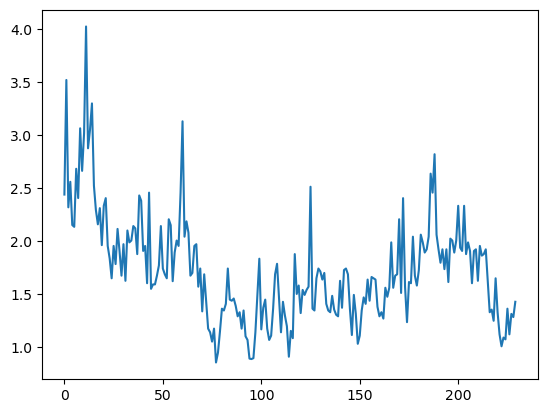

In [134]:
plt.plot(zs)
plt.show()

In [86]:
degree_distribution(hist_gs[a])

NameError: name 'a' is not defined

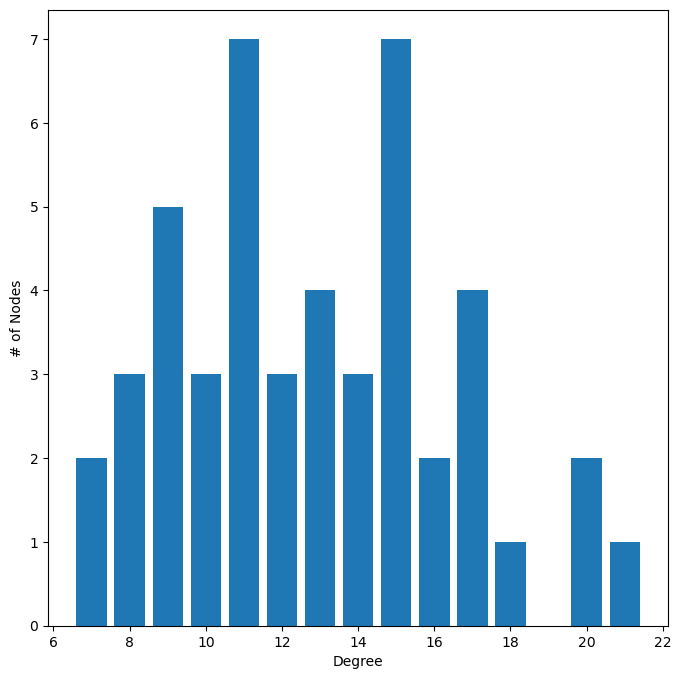

In [135]:
degree_distribution(world.G)

In [88]:
worse_graph = nx.read_adjlist("./prog_g.adjlist")
w_degree_sequence = np.unique(sorted((d for _, d in worse_graph.degree()), reverse=True), return_counts = True)[1]


degree_sequence = np.unique(sorted((d for _, d in world.G.degree()), reverse=True),
                                        return_counts = True)[1]
top = (degree_sequence.mean() - w_degree_sequence.mean()) 
bot1 = np.square(np.std(degree_sequence) / np.sqrt(degree_sequence.shape[0]))
bot2 = np.square(np.std(w_degree_sequence)) / np.sqrt(w_degree_sequence.shape[0])
print(f"Z-score : {top / np.sqrt(bot1 + bot2)}")

ks_2samp(degree_sequence, w_degree_sequence)
print(f"ks_2 sample : {ks_2samp(degree_sequence, w_degree_sequence)}")

Z-score : 1.1335549796631421
ks_2 sample : KstestResult(statistic=0.2878787878787879, pvalue=0.3530992024672486)


In [89]:
ks_2samp(degree_sequence, w_degree_sequence)

KstestResult(statistic=0.2878787878787879, pvalue=0.3530992024672486)

In [90]:
plens

[2.0,
 3.5392670157068062,
 4.329317269076305,
 6.169287696577244,
 7.160962072155412,
 6.424606845513414,
 5.604070305272895,
 5.13413506012951,
 4.876965772432932,
 4.921369102682701,
 4.842738205365403,
 5.124884366327475,
 4.938945420906568,
 4.499537465309898,
 4.698427382053654,
 4.541165587419057,
 4.888991674375578,
 4.896392229417207,
 5.207215541165588,
 4.6096207215541165]

In [136]:
rand_g = nx.random_reference(world.G)
latt_g = nx.lattice_reference(world.G)

In [137]:
C = nx.average_clustering(world.G)
L = nx.average_shortest_path_length(world.G)

In [138]:
Cr = nx.average_clustering(rand_g)
Lr = nx.average_shortest_path_length(rand_g)

In [139]:
Cl = nx.average_clustering(latt_g)

In [140]:
sigma = (C / Cr) / (L / Lr)
# print(sigma)

omega = (Lr / L) - (C / Cl)
print(omega)

0.24458191812288466


In [141]:
# print(nx.sigma(world.G, niter=1, nrand=1))
print(nx.omega(world.G, niter=1, nrand=1))

-0.015239096163951693


In [50]:
print(nx.sigma(world.G))

KeyboardInterrupt: 